In [1]:
%load_ext autoreload
%autoreload 2

## (1) Notebook Setting


In [2]:
import os
import dotenv
import torch
from torch import nn
import pandas as pd
import numpy as np
import random
import mlflow
from uuid import uuid4
from tqdm import tqdm
from sklearn import metrics
from torch.utils.data import DataLoader

In [3]:
os.chdir("./../")

In [4]:
dotenv.load_dotenv("./.env")

True

In [5]:
from src import utils
from src.dataset import RatingDataset
from src.model import BSTRecommenderModel

In [6]:
# Set random seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [7]:
TRACKING_URL = "http://175.41.182.223:5050/"
EXPERIMENT_NAME = "bst-movielens1m-recommender-training"

## (2) Load Prepared Data


In [8]:
train_data = pd.read_parquet("artifacts/train_data.parquet")
test_data = pd.read_parquet("artifacts/test_data.parquet")

In [9]:
train_data.head()

,movie_sequence,genres_ids_sequence,sex,age_group_index,target_movie,target_rating
0,"[3118, 1010, 0, 0, 0, 0]","[[8, 0, 0, 0], [3, 4, 12, 0], [0, 0, 0, 0], [0...",1.0,1,1010,1.00
1,"[1010, 1673, 0, 0, 0, 0]","[[3, 4, 12, 0], [8, 14, 0, 0], [0, 0, 0, 0], [...",1.0,1,1673,0.75
2,"[1673, 1251, 0, 0, 0, 0]","[[8, 14, 0, 0], [5, 15, 0, 0], [0, 0, 0, 0], [...",1.0,1,1251,1.00
3,"[1251, 2272, 0, 0, 0, 0]","[[5, 15, 0, 0], [14, 0, 0, 0], [0, 0, 0, 0], [...",1.0,1,2272,0.50
4,"[2272, 1769, 0, 0, 0, 0]","[[14, 0, 0, 0], [8, 0, 0, 0], [0, 0, 0, 0], [0...",1.0,1,1769,1.00


## (3) Model Config


In [10]:
sequence_length = len(train_data.iloc[0]["movie_sequence"])
print(f"sequence_length:{sequence_length}")

sequence_length:6


In [11]:
age_group_id_map_dict_path = "./artifacts/age_group_id_map_dict.pkl"
age_group_id_map_dict = utils.open_object(age_group_id_map_dict_path)

movie_id_map_dict_path = "./artifacts/movie_id_map_dict.pkl"
movie_id_map_dict = utils.open_object(movie_id_map_dict_path)

age_group_id_map_dict_path = "./artifacts/age_group_id_map_dict.pkl"
age_group_id_map_dict = utils.open_object(age_group_id_map_dict_path)

genres_map_dict_path = "./artifacts/genres_map_dict.pkl"
genres_map_dict = utils.open_object("./artifacts/genres_map_dict.pkl")

min_max_scaler_path = "./artifacts/rating_min_max_scaler.pkl"
min_max_scaler = utils.open_object("./artifacts/rating_min_max_scaler.pkl")

In [12]:
num_movie = len(movie_id_map_dict)
num_age_group = len(age_group_id_map_dict)
num_genre = len(genres_map_dict)

In [13]:
embed_configs = {}
EMED_DIM = 32
embed_configs["movie"] = {"embed_dim": EMED_DIM, "num_embed": num_movie}
embed_configs["genre"] = {"embed_dim": EMED_DIM, "num_embed": num_genre}
embed_configs["age_group"] = {
    "embed_dim": EMED_DIM, "num_embed": num_age_group}
embed_configs["position"] = {
    "embed_dim": EMED_DIM, "num_embed": sequence_length}

In [14]:
config_dict = {}
config_dict["embed_configs"] = embed_configs
config_dict["transformer_num_layer"] = 3
config_dict["dropout"] = 0.2
config_dict["epoches"] = 1
config_dict["learning_rate"] = 0.001
config_dict["batch_size"] = 128
config_dict["sequence_length"] = sequence_length

In [15]:
config_dict["device"] = "cuda" if torch.cuda.is_available() else "cpu"

In [16]:
utils.save_json(config_dict, "./artifacts/config.json")

In [17]:
config = utils.Config(dict=config_dict)

## (5) Load Datasets


In [18]:
train_data["genres_ids_sequence"] = train_data["genres_ids_sequence"].apply(
    lambda x: [array.tolist() for array in x]
)
test_data["genres_ids_sequence"] = test_data["genres_ids_sequence"].apply(
    lambda x: [array.tolist() for array in x]
)

In [19]:
train_dataset = RatingDataset(data=train_data)
test_dataset = RatingDataset(data=test_data)

In [20]:
train_loader = DataLoader(
    train_dataset, batch_size=config.batch_size, shuffle=True)
test_loader = DataLoader(
    test_dataset, batch_size=config.batch_size, shuffle=True)

In [21]:
for inputs in train_loader:
    break

In [22]:
from src.model import BSTRecommenderModel

In [23]:
model = BSTRecommenderModel(config)
model = model.to(config.device)
model.train()

BSTRecommenderModel(
  (embedding_layers): ModuleDict(
    (movie): Embedding(3884, 32)
    (genre): Embedding(19, 32)
    (age_group): Embedding(8, 32)
    (position): Embedding(6, 32)
  )
  (transformer_layer): TransformerLayer(
    (transformer_blocks): ModuleList(
      (0-2): 3 x TransformerBlock(
        (multihead_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=96, out_features=96, bias=True)
        )
        (layer_norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (feed_forward): Sequential(
          (0): Linear(in_features=96, out_features=384, bias=True)
          (1): ReLU()
          (2): Linear(in_features=384, out_features=96, bias=True)
          (3): Dropout(p=0.2, inplace=False)
        )
        (layer_norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (mlp): MLP(
    (dropout): Dropout(p=0.2, inplace=False)
    (layers)

## (6) Training


In [24]:
loss_func = nn.L1Loss()

In [25]:
def evaluate(model, dataset_loader, min_max_scaler, loss_func=nn.L1Loss()):
    model.eval()

    prob_list = []
    rating_list = []
    eval_loss_list = []

    # loss_func = nn.MSELoss()

    pbar = tqdm(total=len(dataset_loader), desc="", position=0, leave=True)

    for inputs in dataset_loader:
        with torch.no_grad():
            probs = model(inputs)
            ratings = inputs["target_rating"].view(-1, 1)

            loss = loss_func(probs, ratings)
            eval_loss_list.append(loss.item())

            probs = probs.cpu().numpy().flatten().tolist()
            prob_list.extend(probs)

            ratings = ratings.cpu().numpy().flatten().tolist()
            rating_list.extend(ratings)

            pbar.update(1)

    pbar.close()

    real_ratings = min_max_scaler.inverse_transform(
        np.array(rating_list).reshape(-1, 1)
    )[:, 0]
    prediction_ratings = min_max_scaler.inverse_transform(
        np.array(prob_list).reshape(-1, 1)
    )[:, 0]

    MAE = metrics.mean_absolute_error(real_ratings, prediction_ratings)
    MSE = metrics.mean_squared_error(real_ratings, prediction_ratings)

    eval_metrics = {}
    eval_metrics["eval_loss"] = sum(eval_loss_list) / len(eval_loss_list)
    eval_metrics["eval_MAE"] = MAE
    eval_metrics["eval_MSE"] = MSE

    return eval_metrics

In [26]:
# loss before training
before_training_metrics = evaluate(
    model, test_loader, min_max_scaler, loss_func)
print(before_training_metrics)

  0%|          | 0/5747 [00:00<?, ?it/s]

100%|██████████| 5747/5747 [01:24<00:00, 68.24it/s]


{'eval_loss': 0.27256317931931184, 'eval_MAE': 1.0902494875393067, 'eval_MSE': 1.7157038274189336}


In [27]:
learning_rate = config_dict["learning_rate"]
batch_size = config_dict["batch_size"]

In [28]:
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
total_batch = 0
best_eval_loss = float("inf")
best_checkpoint = 0
model_version = str(uuid4())
config.eval_steps = len(train_loader) // 3

In [29]:
base_step = 64

In [30]:
# Train
mlflow.set_tracking_uri(TRACKING_URL)
mlflow.set_experiment(EXPERIMENT_NAME)

total_pbar = tqdm(
    total=len(train_loader) * config.epoches, desc="Training", position=0, leave=True
)

metrics_list = []
best_model_path = None


with mlflow.start_run():
    # model_name = 'bst-model'
    # mlflow.set_tag("algorithm",model_name)

    mlflow.log_params(config_dict)
    mlflow.log_artifact("./src", artifact_path="")
    mlflow.log_artifact("./artifacts", artifact_path="")

    for epoch in range(config.epoches):
        train_loss_list = []
        prob_list = []
        rating_list = []

        for inputs in train_loader:
            model = model.train()
            optimizer.zero_grad()
            probs = model(inputs)

            rating = inputs["target_rating"].view(-1, 1)

            loss = loss_func(probs, rating)
            loss.backward()
            optimizer.step()
            train_loss_list.append(loss.item())

            probs = probs.detach().cpu().numpy().flatten().tolist()
            prob_list.extend(probs)
            rating = rating.detach().cpu().flatten().tolist()
            rating_list.extend(rating)

            if (total_batch + 1) % config.eval_steps == 0:
                current_steps = ((total_batch + 1) * batch_size) // base_step
                improve = False
                model_metrics = evaluate(
                    model, test_loader, min_max_scaler, loss_func)
                eval_loss = model_metrics["eval_loss"]

                if eval_loss <= best_eval_loss:
                    improve = True
                    best_checkpoint = current_steps
                    best_eval_loss = eval_loss

                train_loss = np.mean(train_loss_list)

                real_ratings = min_max_scaler.inverse_transform(
                    np.array(rating_list).reshape(-1, 1)
                )[:, 0]
                prediction_ratings = min_max_scaler.inverse_transform(
                    np.array(prob_list).reshape(-1, 1)
                )[:, 0]
                MAE = metrics.mean_absolute_error(
                    real_ratings, prediction_ratings)
                MSE = metrics.mean_squared_error(
                    real_ratings, prediction_ratings)

                model_metrics["best_eval_loss"] = best_eval_loss
                model_metrics["train_loss"] = train_loss
                model_metrics["train_MAE"] = MAE
                model_metrics["train_MSE"] = MSE

                model_metrics["steps"] = current_steps
                model_metrics["best_checkpoint"] = best_checkpoint
                metrics_list.append(model_metrics)

                for metrics_name, metrics_value in model_metrics.items():
                    mlflow.log_metric(metrics_name, metrics_value)

                if improve:
                    save_dir = os.path.join("models", model_version)
                    os.makedirs(save_dir, exist_ok=True)
                    model_path = utils.save_model(
                        model, save_dir, current_steps, model_metrics
                    )
                    best_model_path = model_path
                    mlflow.log_artifact(model_path, artifact_path="model")
                    mlflow.pytorch.log_model(model, "model")

                post_fix_message = {k: round(v, 3)
                                    for k, v in model_metrics.items()}
                total_pbar.set_postfix(post_fix_message)

                model = model.train()

            total_batch += 1
            total_pbar.update(1)

        model = model.train()

    total_pbar.close()

100%|██████████| 5747/5747 [02:01<00:00, 47.26it/s], 18.81it/s, eval_loss=0.19, eval_MAE=0.76, eval_MSE=1.06, best_eval_loss=0.19, train_loss=0.196, train_MAE=0.782, train_MSE=1.08, steps=21744, best_checkpoint=21744]    
/opt/homebrew/Caskroom/miniforge/base/envs/torch/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/torch/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
100%|██████████| 5747/5747 [01:58<00:0

In [31]:
df_metrics = pd.DataFrame(metrics_list)
df_metrics = df_metrics.set_index("steps")
df_metrics

,eval_loss,eval_MAE,eval_MSE,best_eval_loss,train_loss,train_MAE,train_MSE,best_checkpoint
steps,,,,,,,,
21744,0.190108,0.760445,1.056168,0.190108,0.195603,0.782411,1.080604,21744
43488,0.186304,0.745226,1.020425,0.186304,0.192039,0.768157,1.058916,43488
65232,0.184567,0.738334,1.017258,0.184567,0.190180,0.760722,1.046893,65232


<Axes: xlabel='steps'>

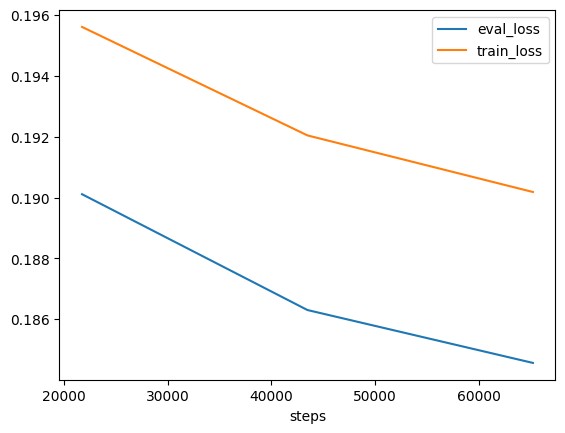

In [32]:
df_metrics[["eval_loss", "train_loss"]].plot()

<Axes: xlabel='steps'>

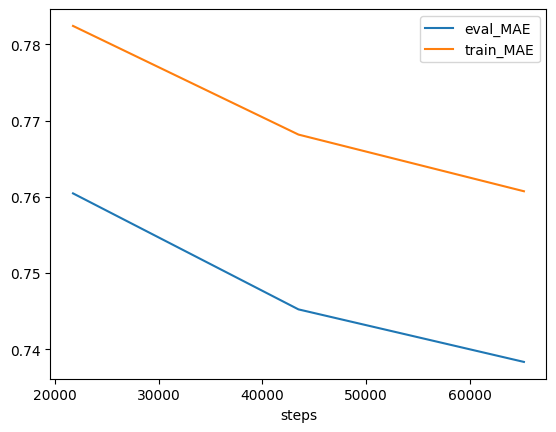

In [33]:
df_metrics[["eval_MAE", "train_MAE"]].plot()

## (7) Validate The Best Model


In [34]:
best_model = BSTRecommenderModel(config=config)

In [35]:
best_model.load_state_dict(torch.load(best_model_path))
best_model.eval()
best_model.to(config.device)

BSTRecommenderModel(
  (embedding_layers): ModuleDict(
    (movie): Embedding(3884, 32)
    (genre): Embedding(19, 32)
    (age_group): Embedding(8, 32)
    (position): Embedding(6, 32)
  )
  (transformer_layer): TransformerLayer(
    (transformer_blocks): ModuleList(
      (0-2): 3 x TransformerBlock(
        (multihead_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=96, out_features=96, bias=True)
        )
        (layer_norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (feed_forward): Sequential(
          (0): Linear(in_features=96, out_features=384, bias=True)
          (1): ReLU()
          (2): Linear(in_features=384, out_features=96, bias=True)
          (3): Dropout(p=0.2, inplace=False)
        )
        (layer_norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (mlp): MLP(
    (dropout): Dropout(p=0.2, inplace=False)
    (layers)

In [36]:
best_model.eval()
prob_list = []
rating_list = []
eval_loss_list = []
pbar = tqdm(total=len(test_loader), desc="", position=0, leave=True)
for inputs in test_loader:
    with torch.no_grad():
        probs = best_model(inputs)
        ratings = inputs["target_rating"].view(-1, 1)

        loss = loss_func(probs, ratings)
        eval_loss_list.append(loss.item())

        probs = probs.cpu().numpy().flatten().tolist()
        prob_list.extend(probs)

        ratings = ratings.cpu().numpy().flatten().tolist()
        rating_list.extend(ratings)

        pbar.update(1)

100%|█████████▉| 5744/5747 [01:54<00:00, 54.09it/s]

In [37]:
prediction = pd.DataFrame()
prediction["real"] = min_max_scaler.inverse_transform(
    np.array(rating_list).reshape(-1, 1)
)[:, 0]
prediction["prediction"] = min_max_scaler.inverse_transform(
    np.array(prob_list).reshape(-1, 1)
)[:, 0]

In [38]:
MAE = metrics.mean_absolute_error(prediction["real"], prediction["prediction"])
RMSE = metrics.mean_squared_error(prediction["real"], prediction["prediction"])

In [39]:
print(f"MAE:{MAE},RMSE:{RMSE}")

MAE:0.7383335893923039,RMSE:1.017257942215218


In [40]:
prediction.iloc[-50:]

,real,prediction
735441,2.0,3.001047
735442,1.0,1.005298
735443,5.0,3.999617
735444,3.0,3.000321
735445,2.0,2.998109
735446,4.0,3.977261
735447,3.0,3.005550
735448,5.0,3.984160
735449,4.0,3.003877
735450,3.0,3.005347


100%|██████████| 5747/5747 [02:06<00:00, 54.09it/s]